This notebook compares the gene sets of the same state (e.g. S01) across different cell types. This is to verify that that the state assignments are meaningless between cell types, i.e. cell-type A state S01 has nothing to do with cell-type B state S01.

## Input section

In this section basic parameters can be set to for summary, the subsequent cells can be run in bulk.

### Variables to set

- directory
  - The directory of EcoTyper results to compare the state assignments across cell types in. This may be relative to the project parent directory which can be specified as `{parent}` or the project's results directory which can be specified as `{results}`.

In [4]:
directory = "{results}/drop_hepato"

Other project directories (need not necessarily be edited)

In [5]:
# the parent directory of the EcoTyper project
parent = "/data/users/noahkleinschmidt/EcoTyper"

# script and results directories within the parent
scripts = f"{parent}/scripts"
results = f"{parent}/results"

if directory:
    directory = directory.format( parent = parent, results = results )
else:
    raise Exception( "Please specify a directory to search." )

Now import necessary packages

In [51]:
import eco_helper as eh
import qpcr._auxiliary.graphical as gx
from itertools import combinations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Analysis section

In this section we compare the cell state gene sets across different cell types for the same state.

In [7]:
# get the cell state collection for the cell types present in the directory
states = eh.core.CellStateCollection( directory )
genes = states.get_genes()

Combine the gene sets for each state across the cell types. This will create a dictionary with states as main keys, and dictionaries with cell types as keys and their gene sets as values.

In [23]:
state_sets = {}
for cell_type, subset in zip( genes.cell_types, genes.subsets() ):
    for state, df in subset:
        
        df.insert( 0, "cell_type", cell_type )

        if state in state_sets:
            state_sets[ state ][ cell_type ] = df.index.to_list()
        else:
            state_sets[ state ] = { cell_type : df.index.to_list() }

Now pair-wise compare the set overlap between the cell type state genes within each state.

In [70]:
pairwise_comparisons = {}

for state, sets in state_sets.items():

    length = len(sets)
    comparisons = np.full( ( length, length ), np.nan )

    cell_types = list( sets.keys() )
    combos = combinations( sets.keys(), r = 2 )
    for a, b in combos:
       
        adx, bdx = cell_types.index(a), cell_types.index(b)
        a, b = sets[a], sets[b]
        a, b = set(a), set(b)

        comparison = eh.core.gene_sets.BaseOverlap( a, b )
        comparison = comparison.get( percent = True ).values
        
        comparisons[ adx, bdx ] = comparison
        comparisons[ bdx, adx ] = comparison

    pairwise_comparisons[ state ] = pd.DataFrame( comparisons, index = cell_types, columns = cell_types )

Now visualize the overlaps between the gene sets of the same state between different cell types.

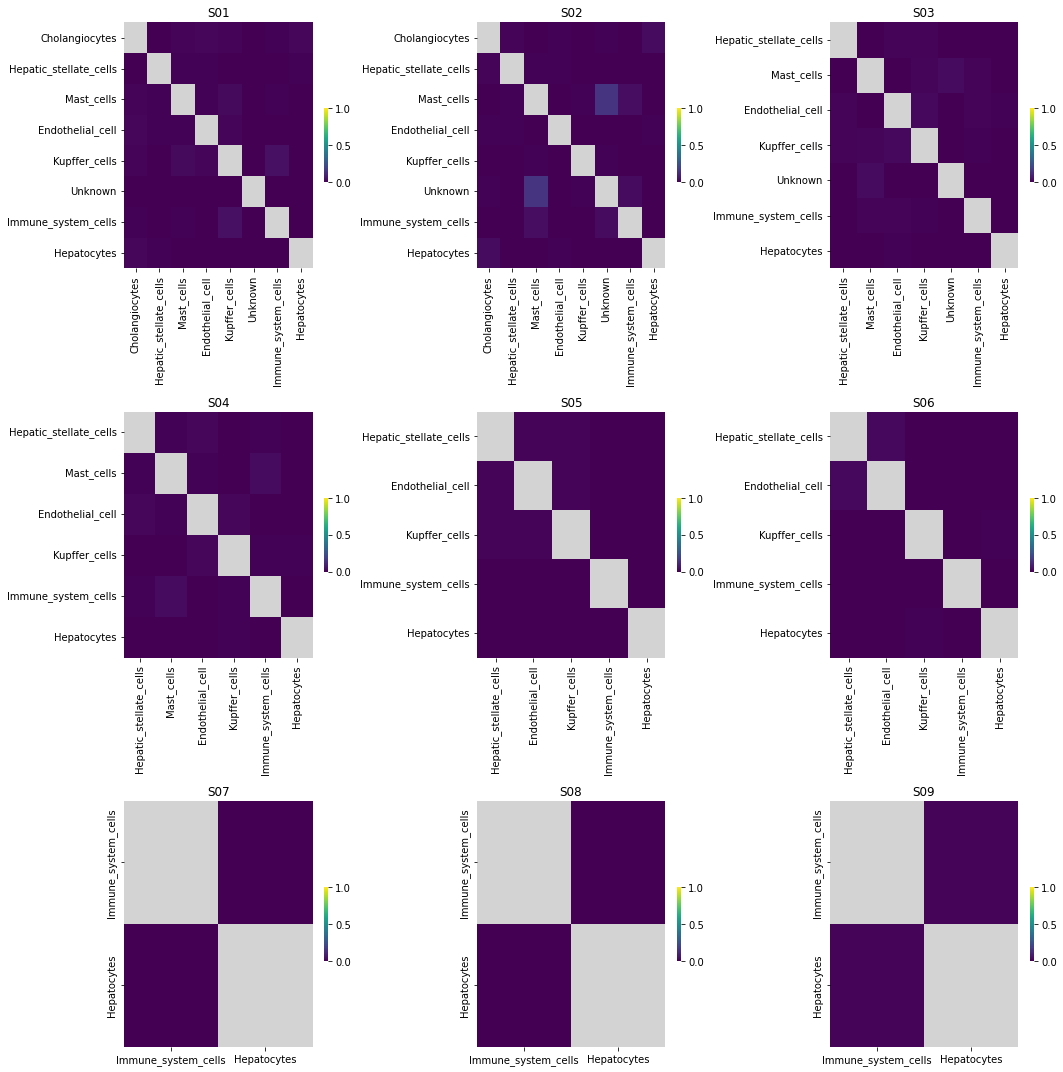

In [71]:
figsize = ( 15, 15 )
ncols, nrows = gx.make_layout_from_list( pairwise_comparisons.keys() )
fig, axs = plt.subplots( nrows = nrows, ncols = ncols, figsize = figsize )

for state, df, ax in zip( pairwise_comparisons.keys(), pairwise_comparisons.values(), axs.flat ):
    h = sns.heatmap( df, ax = ax, cbar = True, cmap = "viridis", vmin = 0, vmax = 1, cbar_kws = {"shrink" : 0.3} )
    h.set_facecolor( "lightgray" )
    ax.set_title( state )

fig.tight_layout()

In [72]:
# fig.savefig( "/data/users/noahkleinschmidt/EcoTyper/state_genes_over_cell_types.pdf" )